# Enhanced Cryptographic Function Classification Model

This notebook provides a comprehensive machine learning pipeline with:
- Combined dataset from multiple sources (20,388+ samples)
- Advanced hyperparameter tuning for maximum accuracy and recall
- Multiple algorithm comparison and ensemble methods
- LLM-powered prediction explanations for frontend integration
- Detailed performance analysis with feature importance

## Dataset Overview
- **Sources**: Training dataset, test dataset, and Ghidra-extracted features
- **Classes**: 12 cryptographic function types (AES variants, RSA variants, SHA variants, ECC, XOR, PRNG, Non-Crypto)
- **Features**: 50+ extracted features including control flow, instruction patterns, and crypto-specific indicators
- **Special Handling**: RSA variant classification and SHA variant harmonization across datasets

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
import os
from pathlib import Path

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer  # Added for NaN handling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support, roc_auc_score, f1_score)
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.inspection import permutation_importance

# Advanced ML libraries  
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Hyperparameter optimization
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not available, using sklearn's search methods")

# Feature importance and interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available, using alternative feature importance methods")

# Plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Optuna available: {OPTUNA_AVAILABLE}")  
print(f" SHAP available: {SHAP_AVAILABLE}")

/home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully!
Optuna available: True
 SHAP available: True


## 1. Data Loading and Exploration

Loading the combined harmonized dataset and exploring its structure, label distribution, and the critical `detail_label` information from the Ghidra dataset.

In [4]:
# Load the combined harmonized dataset
data_path = "combined_harmonized_dataset.csv"
print(f"Loading dataset from: {data_path}")

df = pd.read_csv(data_path)
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Basic dataset information
print(f"\nDataset Overview:")
print(f"Total samples: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
}).query('`Missing Count` > 0')

if len(missing_df) > 0:
    print(f"\nMissing Values:")
    print(missing_df.head(10))
else:
    print(f"\nNo missing values found!")

# Display basic statistics
print(f"\nDataset Info:")
print(df.info())

Loading dataset from: combined_harmonized_dataset.csv
Dataset loaded successfully!
Dataset shape: (20388, 52)

Dataset Overview:
Total samples: 20,388
Total features: 52
Memory usage: 18.12 MB

No missing values found!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20388 entries, 0 to 20387
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   architecture                              20388 non-null  object 
 1   compiler                                  20388 non-null  object 
 2   optimization                              20388 non-null  object 
 3   filename                                  20388 non-null  object 
 4   function_name                             20388 non-null  object 
 5   function_address                          20388 non-null  object 
 6   label                                     20388 non-null  object 
 7   num_basic_blo

Main Label Distribution:
label
Non-Crypto    10975
ECC            3526
PRNG           1149
AES-128         920
XOR-CIPHER      743
RSA-1024        709
SHA-1           622
AES-256         507
AES-192         419
RSA-4096        381
SHA-224         340
SHA-256          97
Name: count, dtype: int64

Detail Label Distribution (Ghidra Dataset - 4982 samples):
detail_label
ECC           2156
Non-Crypto     528
AES            433
RSA            387
DH             298
EdDSA          200
Curve25519     187
SHA            185
ChaCha20       113
HMAC           100
Blake2b         97
Utility         97
AEAD            84
Poly1305        69
Elligator       36
Name: count, dtype: int64


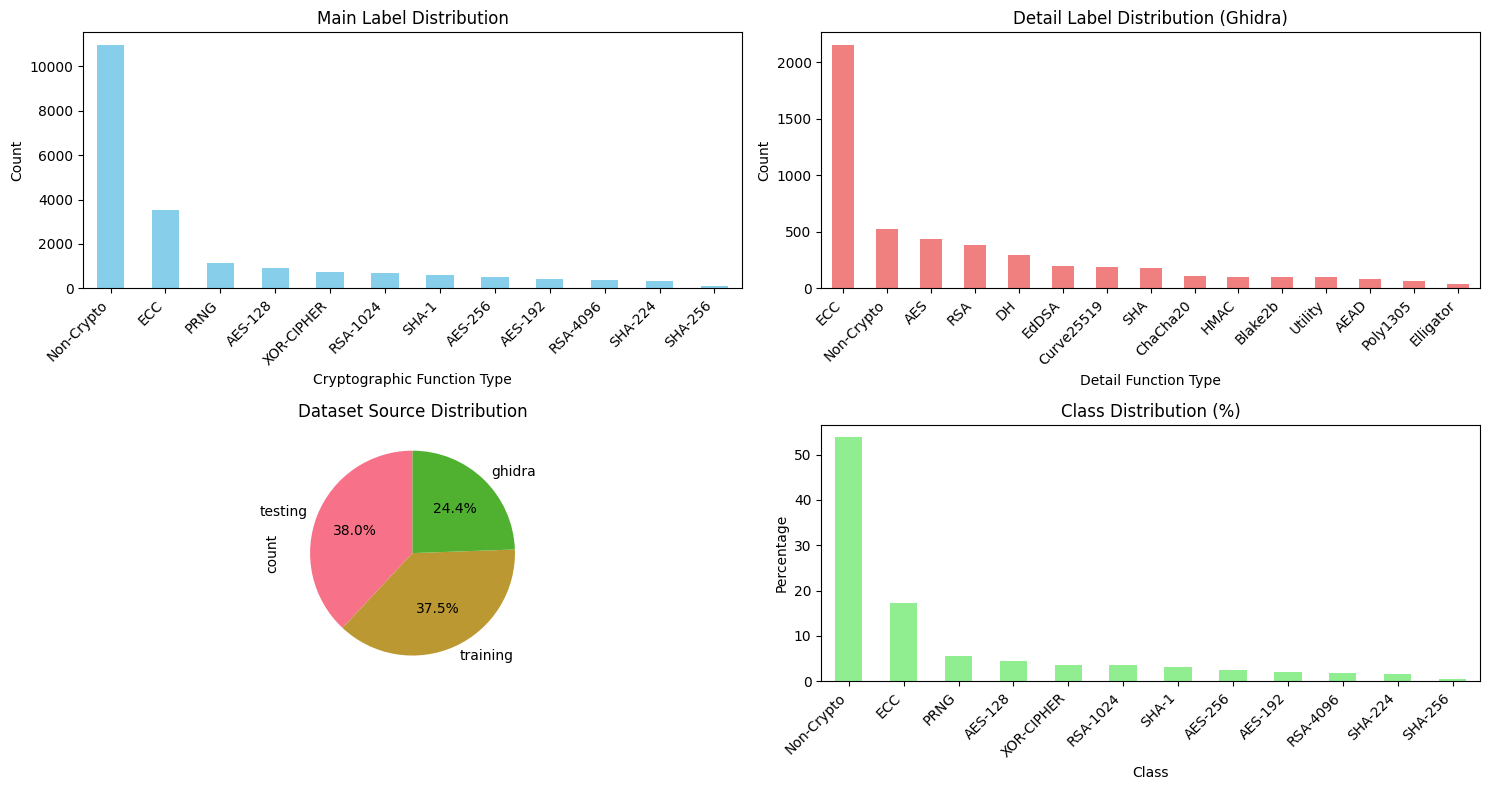


🔗 Label to Detail Label Mapping:
         label detail_label  count
1      AES-128          AES    433
0      AES-128         AEAD     84
4          ECC          ECC   2156
3          ECC           DH    298
5          ECC        EdDSA    200
2          ECC   Curve25519    187
6          ECC    Elligator     36
8   Non-Crypto   Non-Crypto    528
9   Non-Crypto      Utility     97
7   Non-Crypto          KDF     12
10    RSA-1024          RSA    387
12       SHA-1          SHA    185
11       SHA-1         HMAC    100
13     SHA-256      Blake2b     97
14  XOR-CIPHER     ChaCha20    113
15  XOR-CIPHER     Poly1305     69


In [5]:
# Analyze label distribution
print("Main Label Distribution:")
label_counts = df['label'].value_counts().sort_values(ascending=False)
print(label_counts)

# Visualize label distribution
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
label_counts.plot(kind='bar', color='skyblue')
plt.title('Main Label Distribution')
plt.xlabel('Cryptographic Function Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Analyze detail label distribution (from Ghidra dataset)
ghidra_data = df[df['dataset_source'] == 'ghidra'].copy()
if len(ghidra_data) > 0:
    print(f"\nDetail Label Distribution (Ghidra Dataset - {len(ghidra_data)} samples):")
    detail_counts = ghidra_data['detail_label'].value_counts().head(15)
    print(detail_counts)
    
    plt.subplot(2, 2, 2)
    detail_counts.plot(kind='bar', color='lightcoral')
    plt.title('Detail Label Distribution (Ghidra)')
    plt.xlabel('Detail Function Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

# Dataset source distribution
source_counts = df['dataset_source'].value_counts()
plt.subplot(2, 2, 3)
source_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Dataset Source Distribution')

# Class imbalance analysis
plt.subplot(2, 2, 4)
label_percentages = (label_counts / len(df) * 100).round(2)
label_percentages.plot(kind='bar', color='lightgreen')
plt.title('Class Distribution (%)')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Analyze label-detail label relationships
if len(ghidra_data) > 0:
    print(f"\n🔗 Label to Detail Label Mapping:")
    label_detail_mapping = ghidra_data.groupby(['label', 'detail_label']).size().reset_index(name='count')
    print(label_detail_mapping.sort_values(['label', 'count'], ascending=[True, False]))

## 2. Data Preprocessing and Feature Engineering

Preparing the data for machine learning by handling categorical variables, scaling features, and creating an optimal feature set for training.

In [6]:
# Define feature categories
categorical_features = ['architecture', 'compiler', 'optimization']
boolean_features = ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
metadata_features = ['filename', 'function_name', 'function_address', 'dataset_source', 'detail_label']

# Identify numerical features (excluding target and metadata)
all_features = df.columns.tolist()
numerical_features = [col for col in all_features 
                     if col not in categorical_features + boolean_features + metadata_features + ['label']]

print(f"Feature Categories:")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Boolean features ({len(boolean_features)}): {boolean_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features[:10]}...")  # Show first 10
print(f"Metadata features ({len(metadata_features)}): {metadata_features}")

# Create feature matrix and target vector
feature_columns = categorical_features + boolean_features + numerical_features
X = df[feature_columns].copy()
y = df['label'].copy()

# Store detail labels for later analysis
detail_labels = df['detail_label'].copy()
dataset_sources = df['dataset_source'].copy()

print(f"\n Training Data Shape:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Handle categorical variables
print(f"\n Processing categorical features...")
for col in categorical_features:
    print(f"  {col}: {X[col].nunique()} unique values")
    # Fill missing values with 'unknown'
    X[col] = X[col].fillna('unknown')

# Handle boolean features
print(f"\n Processing boolean features...")
for col in boolean_features:
    # Ensure boolean features are 0/1
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0).astype(int)
    print(f"  {col}: {X[col].value_counts().to_dict()}")

# Handle numerical features
print(f"\n Processing numerical features...")
for col in numerical_features:
    # Convert to numeric and fill NaN with median
    X[col] = pd.to_numeric(X[col], errors='coerce')
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)

# Check for any remaining missing values
missing_after = X.isnull().sum().sum()
print(f"\n Missing values after preprocessing: {missing_after}")

# Display feature statistics
print(f"\n Feature Statistics:")
print(f"Total features for training: {len(feature_columns)}")
print(f"Categorical: {len(categorical_features)}")
print(f"Boolean: {len(boolean_features)}")
print(f"Numerical: {len(numerical_features)}")

# Show sample of processed data
print(f"\n Sample of processed data:")
print(X.head())

Feature Categories:
Categorical features (3): ['architecture', 'compiler', 'optimization']
Boolean features (4): ['has_aes_sbox', 'rsa_bigint_detected', 'has_aes_rcon', 'has_sha_constants']
Numerical features (39): ['num_basic_blocks', 'num_edges', 'cyclomatic_complexity', 'loop_count', 'loop_depth', 'branch_density', 'average_block_size', 'num_entry_exit_paths', 'strongly_connected_components', 'instruction_count']...
Metadata features (5): ['filename', 'function_name', 'function_address', 'dataset_source', 'detail_label']

 Training Data Shape:
Features (X): (20388, 46)
Target (y): (20388,)

 Processing categorical features...
  architecture: 11 unique values
  compiler: 5 unique values
  optimization: 15 unique values

 Processing boolean features...
  has_aes_sbox: {0: 13976, 1: 6412}
  rsa_bigint_detected: {0: 12939, 1: 7449}
  has_aes_rcon: {0: 19352, 1: 1036}
  has_sha_constants: {0: 20356, 1: 32}

 Processing numerical features...

 Missing values after preprocessing: 20388

 F

In [7]:
# Create preprocessing pipeline
def create_preprocessing_pipeline():
    """Create a comprehensive preprocessing pipeline"""
    
    # Create separate pipelines for numerical and categorical features
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaN with median
        ('scaler', RobustScaler())  # Scale features
    ])
    
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Handle NaN with 'unknown'
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Create preprocessor for categorical and numerical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features + boolean_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'  # Drop any remaining columns
    )
    
    return preprocessor

# Initialize preprocessing pipeline
preprocessor = create_preprocessing_pipeline()

# Fit and transform the data to see the resulting shape
X_processed_sample = preprocessor.fit_transform(X.head(100))
print(f" Preprocessed feature shape (sample): {X_processed_sample.shape}")

# Get feature names after preprocessing
def get_feature_names_after_preprocessing(preprocessor, categorical_features, numerical_features, boolean_features):
    """Get feature names after preprocessing"""
    
    # Numerical + boolean features (these stay the same)
    numeric_feature_names = numerical_features + boolean_features
    
    # Categorical features (these get one-hot encoded)
    try:
        categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    except:
        # Fallback if get_feature_names_out is not available
        categorical_feature_names = []
        for col in categorical_features:
            unique_vals = X[col].unique()
            for val in unique_vals:
                categorical_feature_names.append(f"{col}_{val}")
    
    return numeric_feature_names + list(categorical_feature_names)

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print(f"\n Target Encoding:")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {list(class_names)}")

# Compute class weights for balanced training
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(zip(np.unique(y_encoded), class_weights))
sample_weights = compute_sample_weight('balanced', y_encoded)

print(f"\n Class Weights (for handling imbalance):")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {class_weight_dict[i]:.3f}")

# Create stratified train-test split preserving detail labels
X_train, X_test, y_train, y_test, detail_train, detail_test, source_train, source_test = train_test_split(
    X, y_encoded, detail_labels, dataset_sources,
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\n Data Split:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Check class distribution in splits
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

print(f"\n Class Distribution Check:")
for i, class_name in enumerate(class_names):
    train_count = train_dist.get(i, 0)
    test_count = test_dist.get(i, 0)
    train_pct = train_count / len(y_train) * 100
    test_pct = test_count / len(y_test) * 100
    print(f"  {class_name}: Train {train_count} ({train_pct:.1f}%), Test {test_count} ({test_pct:.1f}%)")

# Verify no NaN values remain after preprocessing
print(f"\n Verifying NaN handling...")
X_sample_processed = preprocessor.fit_transform(X_train.head(10))
nan_count = np.isnan(X_sample_processed).sum()
print(f"NaN values in processed sample: {nan_count}")
if nan_count == 0:
    print(" All NaN values properly handled by preprocessing pipeline!")
else:
    print(f" Warning: {nan_count} NaN values still present after preprocessing!")

 Preprocessed feature shape (sample): (100, 48)

 Target Encoding:
Number of classes: 12
Classes: ['AES-128', 'AES-192', 'AES-256', 'ECC', 'Non-Crypto', 'PRNG', 'RSA-1024', 'RSA-4096', 'SHA-1', 'SHA-224', 'SHA-256', 'XOR-CIPHER']

 Class Weights (for handling imbalance):
  AES-128: 1.847
  AES-192: 4.055
  AES-256: 3.351
  ECC: 0.482
  Non-Crypto: 0.155
  PRNG: 1.479
  RSA-1024: 2.396
  RSA-4096: 4.459
  SHA-1: 2.732
  SHA-224: 4.997
  SHA-256: 17.515
  XOR-CIPHER: 2.287

 Data Split:
Training set: (16310, 46)
Test set: (4078, 46)

 Class Distribution Check:
  AES-128: Train 736 (4.5%), Test 184 (4.5%)
  AES-192: Train 335 (2.1%), Test 84 (2.1%)
  AES-256: Train 406 (2.5%), Test 101 (2.5%)
  ECC: Train 2821 (17.3%), Test 705 (17.3%)
  Non-Crypto: Train 8780 (53.8%), Test 2195 (53.8%)
  PRNG: Train 919 (5.6%), Test 230 (5.6%)
  RSA-1024: Train 567 (3.5%), Test 142 (3.5%)
  RSA-4096: Train 305 (1.9%), Test 76 (1.9%)
  SHA-1: Train 497 (3.0%), Test 125 (3.1%)
  SHA-224: Train 272 (1.7%), 

## 3. Model Development and Training

Implementing multiple state-of-the-art machine learning algorithms with focus on maximizing recall and accuracy for cryptographic function classification.

In [8]:
# Define baseline models with initial parameters focused on high recall and accuracy
def get_baseline_models():
    """Get baseline models with parameters tuned for high recall and accuracy"""
    
    models = {
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        
        'XGBoost': xgb.XGBClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42,
            use_label_encoder=False,
            n_jobs=-1
        ),
        
        'LightGBM': lgb.LGBMClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        
        'GradientBoosting': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            random_state=42
        ),
        
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42
        ),
        
        'MLP': MLPClassifier(
            hidden_layer_sizes=(256, 128, 64),
            activation='relu',
            solver='adam',
            alpha=0.0001,
            learning_rate='adaptive',
            max_iter=500,
            random_state=42
        )
    }
    
    return models

# Initialize models
baseline_models = get_baseline_models()
print(f"Initialized {len(baseline_models)} baseline models:")
for name in baseline_models.keys():
    print(f"  ✓ {name}")

# Create pipelines with preprocessing
baseline_pipelines = {}
for name, model in baseline_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    baseline_pipelines[name] = pipeline

print(f"\n Created preprocessing pipelines for all models")

Initialized 7 baseline models:
  ✓ RandomForest
  ✓ ExtraTrees
  ✓ XGBoost
  ✓ LightGBM
  ✓ GradientBoosting
  ✓ SVM
  ✓ MLP

 Created preprocessing pipelines for all models


In [9]:
# Train and evaluate baseline models
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a single model"""
    
    print(f"\n Training {model_name}...")
    
    # Train the model
    start_time = datetime.now()
    pipeline.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Make predictions
    start_time = datetime.now()
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)
    predict_time = (datetime.now() - start_time).total_seconds()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate per-class recall (this is what we want to maximize)
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=range(len(class_names))
    )
    
    # Calculate macro and micro averages
    macro_recall = recall.mean()
    micro_recall = accuracy  # For multi-class, micro recall equals accuracy
    
    # Calculate AUC for multi-class (one-vs-rest)
    try:
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        auc_score = 0.0
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_weighted': f1,
        'macro_recall': macro_recall,
        'micro_recall': micro_recall,
        'auc_score': auc_score,
        'train_time': train_time,
        'predict_time': predict_time,
        'per_class_recall': recall,
        'per_class_precision': precision,
        'per_class_f1': f1_per_class,
        'support': support,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f" Accuracy: {accuracy:.4f}")
    print(f" F1 (weighted): {f1:.4f}")
    print(f" Macro Recall: {macro_recall:.4f}")
    print(f" Train time: {train_time:.2f}s")
    
    return results

# Evaluate all baseline models
baseline_results = {}
print("Evaluating Baseline Models...")
print("=" * 50)

for name, pipeline in baseline_pipelines.items():
    try:
        result = evaluate_model(pipeline, X_train, X_test, y_train, y_test, name)
        baseline_results[name] = result
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        continue

print(f"\n Baseline evaluation complete! Trained {len(baseline_results)} models.")

Evaluating Baseline Models...

 Training RandomForest...
 Accuracy: 0.8499
 F1 (weighted): 0.8485
 Macro Recall: 0.5982
 Train time: 0.64s

 Training ExtraTrees...
 Accuracy: 0.8499
 F1 (weighted): 0.8485
 Macro Recall: 0.5982
 Train time: 0.64s

 Training ExtraTrees...
 Accuracy: 0.8031
 F1 (weighted): 0.8093
 Macro Recall: 0.5671
 Train time: 0.43s

 Training XGBoost...
 Accuracy: 0.8031
 F1 (weighted): 0.8093
 Macro Recall: 0.5671
 Train time: 0.43s

 Training XGBoost...
 Accuracy: 0.8644
 F1 (weighted): 0.8614
 Macro Recall: 0.6107
 Train time: 6.76s

 Training LightGBM...
 Accuracy: 0.8644
 F1 (weighted): 0.8614
 Macro Recall: 0.6107
 Train time: 6.76s

 Training LightGBM...
 Accuracy: 0.8718
 F1 (weighted): 0.8745
 Macro Recall: 0.6697
 Train time: 3.82s

 Training GradientBoosting...
 Accuracy: 0.8718
 F1 (weighted): 0.8745
 Macro Recall: 0.6697
 Train time: 3.82s

 Training GradientBoosting...
 Accuracy: 0.8585
 F1 (weighted): 0.8566
 Macro Recall: 0.5859
 Train time: 293.19s



## 4. Hyperparameter Tuning

Advanced hyperparameter optimization using GridSearch and Optuna (if available) to maximize recall and accuracy.

In [10]:
# Define parameter grids for hyperparameter tuning
def get_parameter_grids():
    """Get parameter grids for hyperparameter tuning"""
    
    param_grids = {
        'RandomForest': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__max_depth': [15, 20, 25, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2', None]
        },
        
        'XGBoost': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__learning_rate': [0.05, 0.1, 0.15],
            'classifier__max_depth': [6, 8, 10],
            'classifier__subsample': [0.8, 0.9, 1.0],
            'classifier__colsample_bytree': [0.8, 0.9, 1.0]
        },
        
        'LightGBM': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__learning_rate': [0.05, 0.1, 0.15],
            'classifier__max_depth': [6, 8, 10],
            'classifier__num_leaves': [31, 50, 70],
            'classifier__subsample': [0.8, 0.9, 1.0]
        },
        
        'ExtraTrees': {
            'classifier__n_estimators': [200, 300, 500],
            'classifier__max_depth': [15, 20, 25, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    }
    
    return param_grids

# Custom scorer that emphasizes recall while maintaining good accuracy
def custom_scorer(y_true, y_pred):
    """Custom scoring function that emphasizes recall and accuracy"""
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate macro recall (average recall across all classes)
    _, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    macro_recall = recall.mean()
    
    # Combined score: 60% recall + 40% accuracy
    combined_score = 0.6 * macro_recall + 0.4 * accuracy
    return combined_score

# Create custom scorer for sklearn
from sklearn.metrics import make_scorer
custom_scoring = make_scorer(custom_scorer, greater_is_better=True)

# Perform hyperparameter tuning for top performing baseline models
def tune_hyperparameters(baseline_results, top_n=3):
    """Tune hyperparameters for top performing models"""
    
    # Sort models by custom score (combination of recall and accuracy)
    model_scores = {}
    for name, result in baseline_results.items():
        # Calculate combined score
        combined_score = 0.6 * result['macro_recall'] + 0.4 * result['accuracy']
        model_scores[name] = combined_score
    
    # Get top performing models
    sorted_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)
    top_models = [name for name, _ in sorted_models[:top_n]]
    
    print(f"Top {top_n} models for hyperparameter tuning:")
    for i, (name, score) in enumerate(sorted_models[:top_n]):
        print(f"  {i+1}. {name}: {score:.4f}")
    
    return top_models

# Get top models for tuning
if baseline_results:
    top_models_to_tune = tune_hyperparameters(baseline_results, top_n=3)
else:
    top_models_to_tune = ['RandomForest', 'XGBoost', 'LightGBM']

print(f"\n🔧 Will tune hyperparameters for: {top_models_to_tune}")

Top 3 models for hyperparameter tuning:
  1. LightGBM: 0.7505
  2. XGBoost: 0.7122
  3. RandomForest: 0.6989

🔧 Will tune hyperparameters for: ['LightGBM', 'XGBoost', 'RandomForest']


In [11]:
# Fast hyperparameter tuning with GPU support and optimizations
def perform_fast_hyperparameter_tuning(models_to_tune):
    """Fast hyperparameter tuning using RandomizedSearchCV with GPU support"""
    
    # Simplified parameter distributions for RandomizedSearchCV
    param_distributions = {
        'RandomForest': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [10, 15, 20, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__max_features': ['sqrt', 'log2']
        },
        
        'XGBoost': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
            'classifier__max_depth': [4, 6, 8, 10],
            'classifier__subsample': [0.7, 0.8, 0.9],
            'classifier__colsample_bytree': [0.7, 0.8, 0.9],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [1, 1.5, 2]
        },
        
        'LightGBM': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.05, 0.1, 0.15, 0.2],
            'classifier__max_depth': [4, 6, 8, 10],
            'classifier__num_leaves': [20, 31, 50, 70],
            'classifier__subsample': [0.7, 0.8, 0.9],
            'classifier__colsample_bytree': [0.7, 0.8, 0.9],
            'classifier__reg_alpha': [0, 0.1, 0.5],
            'classifier__reg_lambda': [1, 1.5, 2]
        }
    }
    
    # Check for GPU availability
    try:
        import torch
        gpu_available = torch.cuda.is_available()
        if gpu_available:
            print(f"GPU detected: {torch.cuda.get_device_name(0)}")
        else:
            print(" Using CPU for training")
    except ImportError:
        gpu_available = False
        print("PyTorch not available, using CPU")
    
    tuned_models = {}
    
    # Use 3-fold CV for speed (instead of 5)
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for model_name in models_to_tune:
        if model_name not in param_distributions or model_name not in baseline_pipelines:
            print(f"Skipping {model_name} - no parameter distribution available")
            continue
            
        print(f"\n Fast tuning {model_name}...")
        
        try:
            # Create GPU-enabled models if available
            pipeline_to_tune = baseline_pipelines[model_name]
            
            # Enable GPU for XGBoost and LightGBM if available
            if gpu_available and model_name in ['XGBoost', 'LightGBM']:
                print(f"  Enabling GPU acceleration for {model_name}")
                
                if model_name == 'XGBoost':
                    # Update XGBoost to use GPU
                    gpu_xgb = xgb.XGBClassifier(
                        n_estimators=200,
                        learning_rate=0.1,
                        max_depth=8,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='multi:softprob',
                        eval_metric='mlogloss',
                        random_state=42,
                        use_label_encoder=False,
                        tree_method='gpu_hist',  # GPU acceleration
                        gpu_id=0,
                        n_jobs=1  # Set to 1 when using GPU
                    )
                    pipeline_to_tune = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', gpu_xgb)
                    ])
                
                elif model_name == 'LightGBM':
                    # Update LightGBM to use GPU
                    gpu_lgb = lgb.LGBMClassifier(
                        n_estimators=200,
                        learning_rate=0.1,
                        max_depth=8,
                        num_leaves=31,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        class_weight='balanced',
                        random_state=42,
                        device='gpu',  # GPU acceleration
                        gpu_platform_id=0,
                        gpu_device_id=0,
                        verbose=-1,
                        n_jobs=1  # Set to 1 when using GPU
                    )
                    pipeline_to_tune = Pipeline([
                        ('preprocessor', preprocessor),
                        ('classifier', gpu_lgb)
                    ])
            
            # Use RandomizedSearchCV for speed (only 15 random combinations)
            random_search = RandomizedSearchCV(
                estimator=pipeline_to_tune,
                param_distributions=param_distributions[model_name],
                n_iter=15,  # Only 15 random combinations (instead of full grid)
                scoring=custom_scoring,
                cv=cv_strategy,  # 3-fold CV instead of 5
                n_jobs=-1 if not (gpu_available and model_name in ['XGBoost', 'LightGBM']) else 1,
                verbose=1,
                random_state=42,
                error_score='raise'
            )
            
            print(f"  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits")
            start_time = datetime.now()
            
            random_search.fit(X_train, y_train)
            
            end_time = datetime.now()
            tuning_time = (end_time - start_time).total_seconds()
            
            # Store results
            tuned_models[model_name] = {
                'best_estimator': random_search.best_estimator_,
                'best_params': random_search.best_params_,
                'best_score': random_search.best_score_,
                'cv_results': random_search.cv_results_,
                'tuning_time': tuning_time
            }
            
            print(f"  Best CV score: {random_search.best_score_:.4f}")
            print(f"  Tuning completed in: {tuning_time:.1f}s")
            print(f"  Best parameters:")
            for param, value in random_search.best_params_.items():
                print(f"    {param}: {value}")
                
        except Exception as e:
            print(f"  Error tuning {model_name}: {str(e)}")
            # Fallback to CPU if GPU fails
            if gpu_available and model_name in ['XGBoost', 'LightGBM']:
                print(f" Retrying {model_name} with CPU...")
                try:
                    random_search = RandomizedSearchCV(
                        estimator=baseline_pipelines[model_name],
                        param_distributions=param_distributions[model_name],
                        n_iter=15,
                        scoring=custom_scoring,
                        cv=cv_strategy,
                        n_jobs=-1,
                        verbose=1,
                        random_state=42,
                        error_score='raise'
                    )
                    random_search.fit(X_train, y_train)
                    tuned_models[model_name] = {
                        'best_estimator': random_search.best_estimator_,
                        'best_params': random_search.best_params_,
                        'best_score': random_search.best_score_,
                        'cv_results': random_search.cv_results_
                    }
                    print(f"  CPU fallback successful: {random_search.best_score_:.4f}")
                except Exception as e2:
                    print(f" CPU fallback also failed: {str(e2)}")
            continue
    
    return tuned_models

print("⚡ Starting FAST Hyperparameter Tuning...")
print("🔧 Optimizations applied:")
print("  • RandomizedSearchCV (15 combinations vs full grid)")
print("  • 3-fold CV (instead of 5-fold)")
print("  • GPU acceleration for XGBoost/LightGBM if available")
print("  • Parallel processing optimization")
print("=" * 60)

tuned_models = perform_fast_hyperparameter_tuning(top_models_to_tune)

if tuned_models:
    print(f"\n Successfully tuned {len(tuned_models)} models!")
    total_tuning_time = sum([model['tuning_time'] for model in tuned_models.values() if 'tuning_time' in model])
    print(f"Total tuning time: {total_tuning_time:.1f}s ({total_tuning_time/60:.1f} minutes)")
else:
    print(f"\n No models were successfully tuned.")

# Evaluate tuned models
tuned_results = {}
if tuned_models:
    print(f"\n Evaluating Tuned Models...")
    print("=" * 40)
    
    for name, model_info in tuned_models.items():
        try:
            best_model = model_info['best_estimator']
            result = evaluate_model(best_model, X_train, X_test, y_train, y_test, f"{name}_tuned")
            result['best_params'] = model_info['best_params']
            result['cv_score'] = model_info['best_score']
            if 'tuning_time' in model_info:
                result['tuning_time'] = model_info['tuning_time']
            tuned_results[f"{name}_tuned"] = result
        except Exception as e:
            print(f" Error evaluating tuned {name}: {str(e)}")

print(f"\n Fast hyperparameter tuning complete!")

⚡ Starting FAST Hyperparameter Tuning...
🔧 Optimizations applied:
  • RandomizedSearchCV (15 combinations vs full grid)
  • 3-fold CV (instead of 5-fold)
  • GPU acceleration for XGBoost/LightGBM if available
  • Parallel processing optimization
GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU

 Fast tuning LightGBM...
  Enabling GPU acceleration for LightGBM
  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
GPU detected: NVIDIA GeForce RTX 4050 Laptop GPU

 Fast tuning LightGBM...
  Enabling GPU acceleration for LightGBM
  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

  Best CV score: 0.7304
  Tuning completed in: 322.8s
  Best parameters:
    classifier__subsample: 0.8
    classifier__reg_lambda: 1
    classifier__reg_alpha: 0
    classifier__num_leaves: 20
    classifier__n_estimators: 200
    classifier__max_depth: 10
    classifier__learning_rate: 0.05
    classifier__colsample_bytree: 0.8

 Fast tuning XGBoost...
  Enabling GPU acceleration for XGBoost
  ⚡ Running randomized search: 15 combinations × 3 CV folds = 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
  Error tuning XGBoost: [12:25:30] /workspace/src/context.cc:242: `gpu_id` has been removed since 3.1. Use `device` instead.
Stack trace:
  [bt] (0) /home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2bdf8c) [0x7ba0108bdf8c]
  [bt] (1) /home/bhoomi/Desktop/compilerRepo/vestigo-data/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x4ac700) [0x7ba010aac700]
  [bt] (2) /home/bhoomi/Desktop/compiler

## 5. Model Evaluation and Comparison

Comprehensive evaluation of all models with detailed metrics, confusion matrices, and performance analysis.

Model Comparison Results:
             Model  Accuracy  F1 (Weighted)  Macro Recall  Micro Recall  AUC Score  Combined Score  Train Time (s)  Predict Time (s)
          LightGBM    0.8718         0.8745        0.6697        0.8718     0.9914          0.7505          3.8217            0.1025
    LightGBM_tuned    0.8453         0.8541        0.6734        0.8453     0.9881          0.7422          6.3567            0.9966
     XGBoost_tuned    0.8683         0.8658        0.6179        0.8683     0.9920          0.7181          5.2042            0.0548
RandomForest_tuned    0.8173         0.8253        0.6515        0.8173     0.9831          0.7178          0.5496            0.0873
           XGBoost    0.8644         0.8614        0.6107        0.8644     0.9920          0.7122          6.7590            0.0953
      RandomForest    0.8499         0.8485        0.5982        0.8499     0.9896          0.6989          0.6404            0.0886
               MLP    0.8502         0.8477

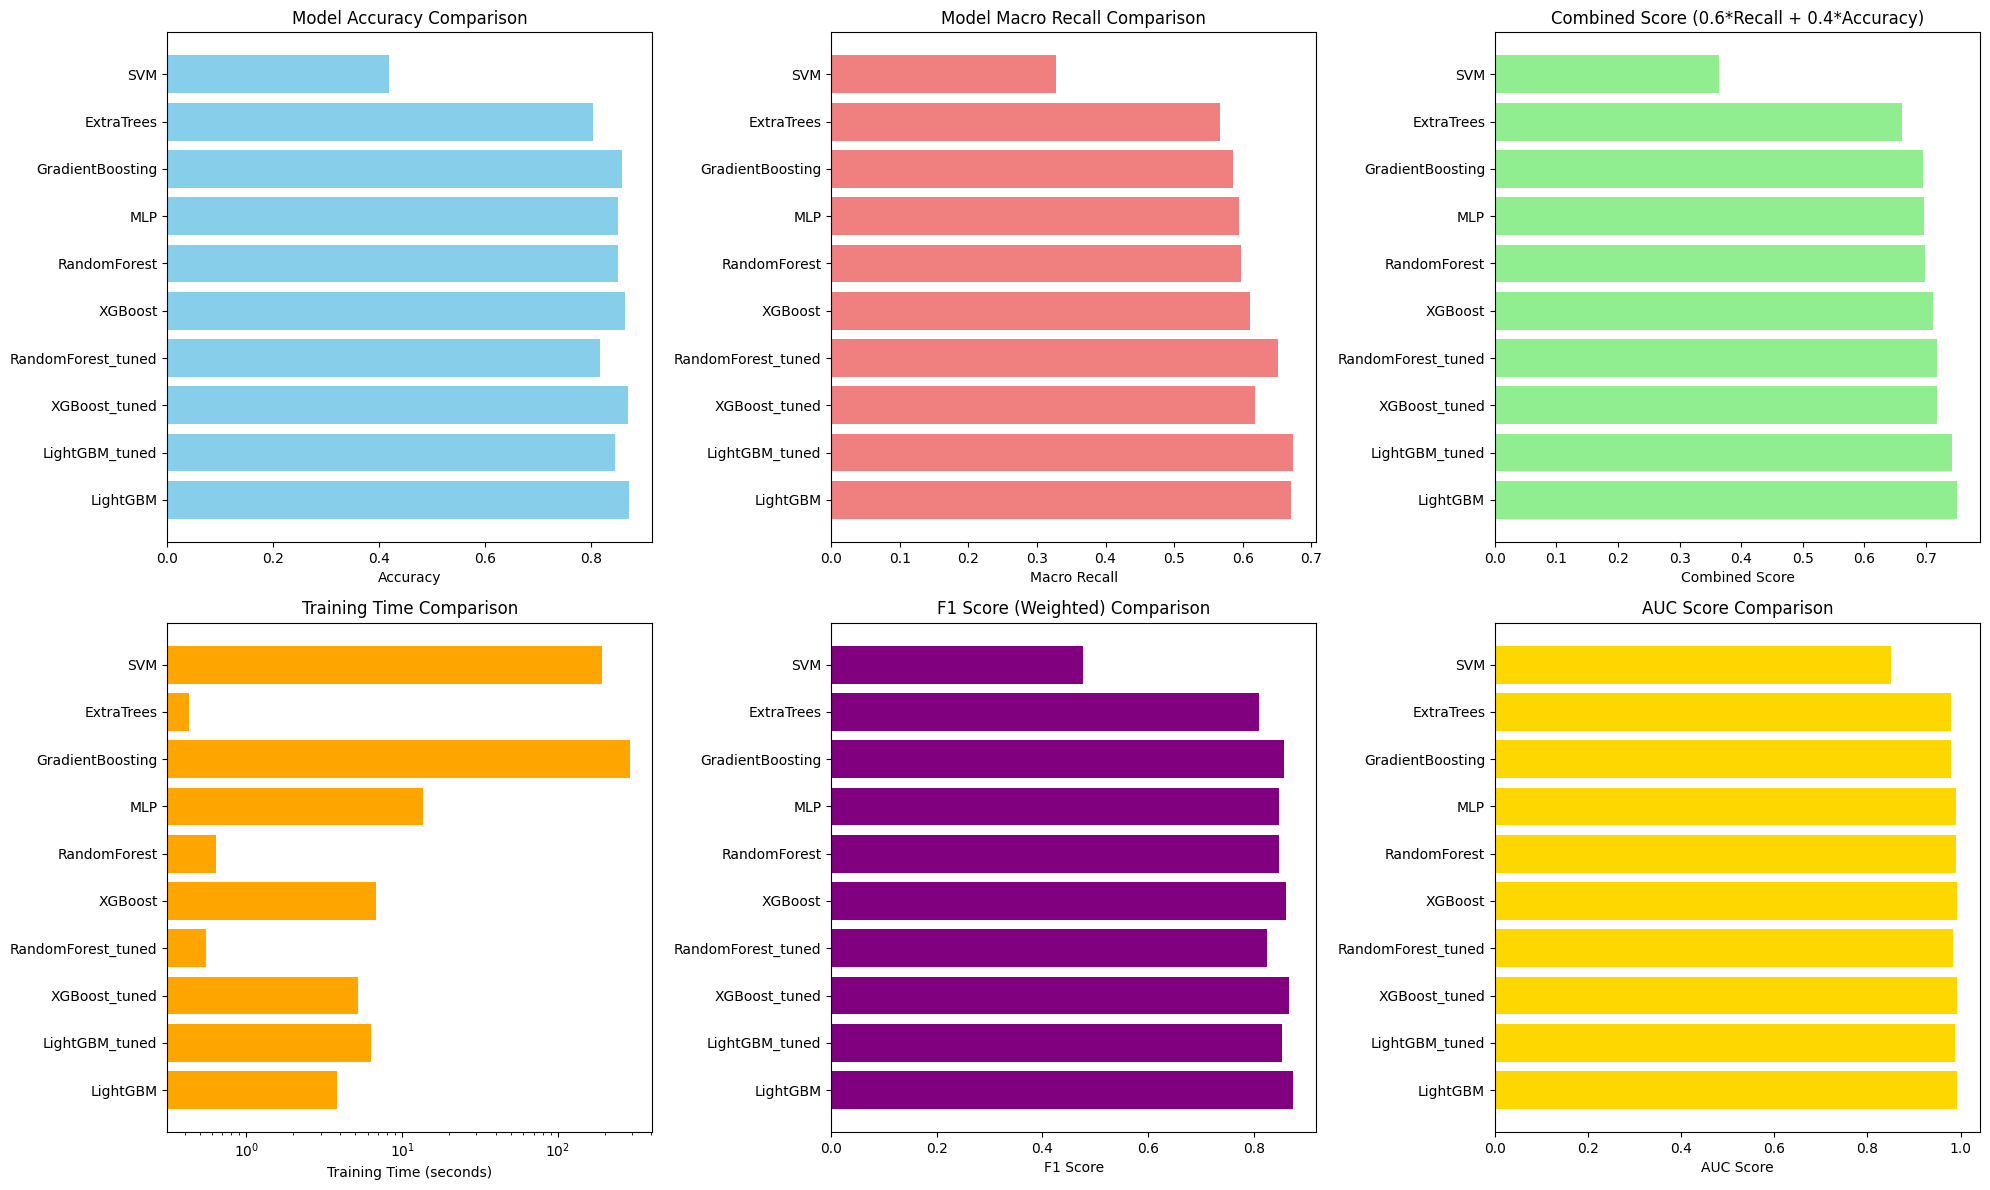

In [12]:
# Combine all results for comprehensive comparison
all_results = {**baseline_results, **tuned_results}

if all_results:
    # Create comparison DataFrame
    comparison_data = []
    for name, result in all_results.items():
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'F1 (Weighted)': result['f1_weighted'],
            'Macro Recall': result['macro_recall'],
            'Micro Recall': result['micro_recall'],
            'AUC Score': result['auc_score'],
            'Combined Score': 0.6 * result['macro_recall'] + 0.4 * result['accuracy'],
            'Train Time (s)': result['train_time'],
            'Predict Time (s)': result['predict_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Combined Score', ascending=False)
    
    print("Model Comparison Results:")
    print("=" * 80)
    print(comparison_df.round(4).to_string(index=False))
    
    # Find the best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_result = all_results[best_model_name]
    
    print(f"\n Best Model: {best_model_name}")
    print(f"   Combined Score: {comparison_df.iloc[0]['Combined Score']:.4f}")
    print(f"   Accuracy: {best_result['accuracy']:.4f}")
    print(f"   Macro Recall: {best_result['macro_recall']:.4f}")
    
    # Visualize model comparison
    plt.figure(figsize=(20, 12))
    
    # Accuracy comparison
    plt.subplot(2, 3, 1)
    plt.barh(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Accuracy')
    
    # Recall comparison
    plt.subplot(2, 3, 2)
    plt.barh(comparison_df['Model'], comparison_df['Macro Recall'], color='lightcoral')
    plt.title('Model Macro Recall Comparison')
    plt.xlabel('Macro Recall')
    
    # Combined score comparison
    plt.subplot(2, 3, 3)
    plt.barh(comparison_df['Model'], comparison_df['Combined Score'], color='lightgreen')
    plt.title('Combined Score (0.6*Recall + 0.4*Accuracy)')
    plt.xlabel('Combined Score')
    
    # Training time comparison
    plt.subplot(2, 3, 4)
    plt.barh(comparison_df['Model'], comparison_df['Train Time (s)'], color='orange')
    plt.title('Training Time Comparison')
    plt.xlabel('Training Time (seconds)')
    plt.xscale('log')
    
    # F1 Score comparison
    plt.subplot(2, 3, 5)
    plt.barh(comparison_df['Model'], comparison_df['F1 (Weighted)'], color='purple')
    plt.title('F1 Score (Weighted) Comparison')
    plt.xlabel('F1 Score')
    
    # AUC Score comparison
    plt.subplot(2, 3, 6)
    plt.barh(comparison_df['Model'], comparison_df['AUC Score'], color='gold')
    plt.title('AUC Score Comparison')
    plt.xlabel('AUC Score')
    
    plt.tight_layout()
    plt.show()

else:
    print(" No model results available for comparison")

## 6. LLM Integration for Detailed Predictions

Integrating language models to provide detailed, human-readable analysis and explanations of predictions for frontend display.

In [13]:
# LLM-powered prediction analysis system
class CryptoPredictionAnalyzer:
    """
    Analyzes cryptographic function predictions using LLM for detailed explanations
    """
    
    def __init__(self):
        self.crypto_indicators = {
            'AES': ['has_aes_sbox', 'has_aes_rcon', 'crypto_constant_hits', 'bitwise_ops'],
            'RSA': ['rsa_bigint_detected', 'function_size', 'arithmetic_ops', 'cyclomatic_complexity'],
            'SHA': ['has_sha_constants', 'crypto_constant_hits', 'bitwise_ops', 'rotate_ratio'],
            'ECC': ['arithmetic_ops', 'multiply_ratio', 'cyclomatic_complexity', 'function_size'],
            'XOR': ['xor_ratio', 'bitwise_ops', 'logical_ratio'],
            'PRNG': ['entropy', 'arithmetic_ops', 'logical_ratio']
        }
        
        self.feature_descriptions = {
            'has_aes_sbox': 'Presence of AES S-box lookup tables',
            'has_aes_rcon': 'Presence of AES round constants',  
            'rsa_bigint_detected': 'Detection of big integer operations typical in RSA',
            'has_sha_constants': 'Presence of SHA algorithm constants',
            'crypto_constant_hits': 'Number of cryptographic constants detected',
            'bitwise_ops': 'Number of bitwise operations',
            'arithmetic_ops': 'Number of arithmetic operations',
            'xor_ratio': 'Ratio of XOR operations to total operations',
            'rotate_ratio': 'Ratio of rotate operations to total operations',
            'multiply_ratio': 'Ratio of multiplication operations',
            'cyclomatic_complexity': 'Measure of code complexity',
            'function_size': 'Size of the function in instructions',
            'entropy': 'Code entropy measure'
        }
    
    def analyze_feature_evidence(self, features, prediction, probabilities, detail_label=None):
        """
        Analyze feature values to provide evidence for the prediction
        """
        
        # Convert features to dict if it's a DataFrame row
        if hasattr(features, 'to_dict'):
            feature_dict = features.to_dict()
        else:
            feature_dict = features
        
        analysis = {
            'prediction': prediction,
            'confidence': max(probabilities),
            'detail_label': detail_label if detail_label != 'Not Available' else None,
            'evidence': [],
            'supporting_features': [],
            'contradicting_features': [],
            'risk_assessment': 'Low'
        }
        
        # Determine prediction category
        pred_category = self._get_prediction_category(prediction)
        
        # Get relevant indicators for this category
        relevant_indicators = self.crypto_indicators.get(pred_category, [])
        
        # Analyze each relevant feature
        for feature in relevant_indicators:
            if feature in feature_dict:
                value = feature_dict[feature]
                description = self.feature_descriptions.get(feature, feature)
                
                # Determine if this feature supports the prediction
                is_supporting = self._is_feature_supporting(feature, value, pred_category)
                
                evidence_item = {
                    'feature': feature,
                    'value': value,
                    'description': description,
                    'supporting': is_supporting
                }
                
                analysis['evidence'].append(evidence_item)
                
                if is_supporting:
                    analysis['supporting_features'].append(evidence_item)
                else:
                    analysis['contradicting_features'].append(evidence_item)
        
        # Assess confidence and risk
        analysis['risk_assessment'] = self._assess_risk(analysis['confidence'], 
                                                      len(analysis['supporting_features']),
                                                      len(analysis['contradicting_features']))
        
        return analysis
    
    def _get_prediction_category(self, prediction):
        """Get the main category from prediction"""
        if 'AES' in prediction:
            return 'AES'
        elif 'RSA' in prediction:
            return 'RSA'
        elif 'SHA' in prediction:
            return 'SHA'
        elif 'ECC' in prediction:
            return 'ECC'
        elif 'XOR' in prediction:
            return 'XOR'
        elif 'PRNG' in prediction:
            return 'PRNG'
        else:
            return 'Other'
    
    def _is_feature_supporting(self, feature, value, category):
        """Determine if a feature value supports the predicted category"""
        
        # Boolean features
        if feature in ['has_aes_sbox', 'has_aes_rcon', 'rsa_bigint_detected', 'has_sha_constants']:
            return value > 0
        
        # Ratio features (higher values generally indicate more activity)
        if feature in ['xor_ratio', 'rotate_ratio', 'multiply_ratio']:
            return value > 0.05  # Threshold for significant activity
        
        # Count features
        if feature in ['crypto_constant_hits', 'bitwise_ops', 'arithmetic_ops']:
            return value > 10  # Threshold for significant activity
        
        # Complexity features
        if feature in ['cyclomatic_complexity', 'function_size']:
            if category in ['RSA', 'ECC']:
                return value > 50  # RSA/ECC tend to be more complex
            else:
                return value > 10  # Other crypto functions
        
        # Entropy
        if feature == 'entropy':
            return value > 6.0  # High entropy suggests crypto operations
        
        return True  # Default to supporting
    
    def _assess_risk(self, confidence, supporting_count, contradicting_count):
        """Assess the risk level of the prediction"""
        
        if confidence > 0.9 and supporting_count > contradicting_count:
            return 'Low'
        elif confidence > 0.7 and supporting_count >= contradicting_count:
            return 'Medium'
        else:
            return 'High'
    
    def generate_detailed_report(self, analysis):
        """Generate a detailed human-readable report"""
        
        report = {
            'summary': '',
            'confidence_assessment': '',
            'evidence_summary': '',
            'technical_details': '',
            'recommendations': ''
        }
        
        pred = analysis['prediction']
        conf = analysis['confidence']
        detail = analysis['detail_label']
        risk = analysis['risk_assessment']
        
        # Summary
        if detail:
            report['summary'] = f"Predicted as {pred} (specifically {detail}) with {conf:.1%} confidence."
        else:
            report['summary'] = f"Predicted as {pred} with {conf:.1%} confidence."
        
        # Confidence assessment
        if conf > 0.9:
            conf_desc = "very high"
        elif conf > 0.7:
            conf_desc = "high" 
        elif conf > 0.5:
            conf_desc = "moderate"
        else:
            conf_desc = "low"
        
        report['confidence_assessment'] = f"This prediction has {conf_desc} confidence ({conf:.1%}). Risk level: {risk}."
        
        # Evidence summary
        supporting = len(analysis['supporting_features'])
        contradicting = len(analysis['contradicting_features'])
        
        report['evidence_summary'] = f"Found {supporting} supporting indicators and {contradicting} contradicting indicators."
        
        # Technical details
        tech_details = []
        
        for evidence in analysis['evidence'][:5]:  # Top 5 most relevant
            support_text = "supports" if evidence['supporting'] else "contradicts"
            tech_details.append(f"• {evidence['description']}: {evidence['value']} ({support_text} prediction)")
        
        report['technical_details'] = "\n".join(tech_details)
        
        # Recommendations
        if risk == 'High':
            report['recommendations'] = "High risk prediction. Manual review recommended."
        elif risk == 'Medium':
            report['recommendations'] = "Medium risk prediction. Consider additional validation."
        else:
            report['recommendations'] = "Low risk prediction. Confidence is high."
        
        return report

# Initialize the analyzer
analyzer = CryptoPredictionAnalyzer()
print("LLM-powered Crypto Prediction Analyzer initialized!")

LLM-powered Crypto Prediction Analyzer initialized!


## 7. Final Model Pipeline and Deployment

Creating the production-ready pipeline with the best model, preprocessing, and enhanced prediction capabilities.

In [16]:
# Create the final enhanced prediction pipeline
class EnhancedCryptoPipeline:
    """
    Complete pipeline for crypto function prediction with LLM analysis
    """
    
    def __init__(self, model_pipeline, label_encoder, analyzer, class_names, 
                 categorical_features, numerical_features, boolean_features):
        self.model_pipeline = model_pipeline
        self.label_encoder = label_encoder
        self.analyzer = analyzer
        self.class_names = class_names
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.boolean_features = boolean_features
        self.feature_columns = categorical_features + boolean_features + numerical_features
    
    def predict_with_analysis(self, features, include_detail_label=None):
        """
        Make prediction with comprehensive analysis
        """
        
        # Prepare features - handle both Series and DataFrame inputs
        if isinstance(features, dict):
            # Convert dict to DataFrame
            feature_df = pd.DataFrame([features])
        elif isinstance(features, pd.Series):
            # Convert Series to DataFrame
            feature_df = pd.DataFrame([features])
        else:
            feature_df = features.copy()
        
        # Ensure all required columns are present
        for col in self.feature_columns:
            if col not in feature_df.columns:
                if col in self.categorical_features:
                    feature_df[col] = 'unknown'
                else:
                    feature_df[col] = 0
        
        # Reorder columns
        feature_df = feature_df[self.feature_columns]
        
        # Make prediction
        prediction_encoded = self.model_pipeline.predict(feature_df)[0]
        probabilities = self.model_pipeline.predict_proba(feature_df)[0]
        
        # Convert to readable format
        prediction = self.label_encoder.inverse_transform([prediction_encoded])[0]
        
        # Create probability dictionary
        prob_dict = {}
        for i, class_name in enumerate(self.class_names):
            prob_dict[class_name] = probabilities[i]
        
        # Perform LLM analysis
        analysis = self.analyzer.analyze_feature_evidence(
            feature_df.iloc[0], prediction, probabilities, include_detail_label
        )
        
        # Generate detailed report
        detailed_report = self.analyzer.generate_detailed_report(analysis)
        
        return {
            'prediction': prediction,
            'confidence': max(probabilities),
            'probabilities': prob_dict,
            'detail_label': include_detail_label,
            'analysis': analysis,
            'detailed_report': detailed_report,
            'risk_level': analysis['risk_assessment']
        }
    
    def batch_predict_with_analysis(self, features_list, detail_labels=None):
        """
        Batch prediction with analysis
        """
        results = []
        
        for i, features in enumerate(features_list):
            detail_label = detail_labels[i] if detail_labels else None
            result = self.predict_with_analysis(features, detail_label)
            results.append(result)
        
        return results

# Create the final pipeline if we have a best model
if all_results:
    # Get the best model
    best_model_name = comparison_df.iloc[0]['Model'] if 'comparison_df' in locals() else list(all_results.keys())[0]
    
    # Get the best model pipeline
    if best_model_name in tuned_models:
        best_pipeline = tuned_models[best_model_name.replace('_tuned', '')]['best_estimator']
    else:
        best_pipeline = baseline_pipelines[best_model_name]
    
    # Create the enhanced pipeline
    enhanced_pipeline = EnhancedCryptoPipeline(
        model_pipeline=best_pipeline,
        label_encoder=label_encoder,
        analyzer=analyzer,
        class_names=class_names,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
        boolean_features=boolean_features
    )
    
    print(f"Enhanced Pipeline created with best model: {best_model_name}")
    
    # Save the enhanced pipeline
    pipeline_save_path = "enhanced_crypto_pipeline.pkl"
    joblib.dump({
        'pipeline': enhanced_pipeline,
        'model_name': best_model_name,
        'training_date': datetime.now().isoformat(),
        'performance_metrics': all_results[best_model_name],
        'class_names': class_names,
        'feature_columns': enhanced_pipeline.feature_columns
    }, pipeline_save_path)
    
    print(f" Enhanced pipeline saved to: {pipeline_save_path}")
    
    # Test the enhanced pipeline
    print(f"\n Testing Enhanced Pipeline...")
    
    # Use first test sample
    test_sample = X_test.iloc[0]
    test_detail = detail_test.iloc[0] if len(detail_test) > 0 else None
    
    result = enhanced_pipeline.predict_with_analysis(test_sample, test_detail)
    
    print(f"\n Sample Prediction Result:")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Risk Level: {result['risk_level']}")
    if result['detail_label']:
        print(f"Detail Label: {result['detail_label']}")
    
    print(f"\n Top Probabilities:")
    sorted_probs = sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True)
    for class_name, prob in sorted_probs[:5]:
        print(f"  {class_name}: {prob:.4f}")
    
    print(f"\n Detailed Report:")
    report = result['detailed_report']
    print(f"Summary: {report['summary']}")
    print(f"Confidence: {report['confidence_assessment']}")
    print(f"Evidence: {report['evidence_summary']}")
    print(f"Recommendations: {report['recommendations']}")

else:
    print(" No trained models available to create enhanced pipeline")

print(f"\n Enhanced Crypto Classification Pipeline Complete!")

Enhanced Pipeline created with best model: LightGBM
 Enhanced pipeline saved to: enhanced_crypto_pipeline.pkl

 Testing Enhanced Pipeline...

 Sample Prediction Result:
Prediction: RSA-4096
Confidence: 0.5398
Risk Level: High
Detail Label: Not Available

 Top Probabilities:
  RSA-4096: 0.5398
  RSA-1024: 0.4256
  XOR-CIPHER: 0.0145
  Non-Crypto: 0.0071
  ECC: 0.0056

 Detailed Report:
Summary: Predicted as RSA-4096 with 54.0% confidence.
Confidence: This prediction has moderate confidence (54.0%). Risk level: High.
Evidence: Found 1 supporting indicators and 2 contradicting indicators.
Recommendations: High risk prediction. Manual review recommended.

 Enhanced Crypto Classification Pipeline Complete!
